<a href="https://colab.research.google.com/github/Alejandro-XIII/Proyecto-Final-SO/blob/main/Proyecto_Final.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

#Scheduling

##FCFS

In [53]:
def fcfs(processes):
    processes_sorted = sorted(processes, key=lambda x: x['arrival_time'])
    scheduling = []
    time = 0
    for process in processes_sorted:
        time += process['run_time']
        scheduling.append((process['name'], time))
    return scheduling

##SJF

In [54]:
def sjf(processes):
    processes_sorted = sorted(processes, key=lambda x: x['run_time'])
    scheduling = []
    time = 0
    for process in processes_sorted:
        time += process['run_time']
        scheduling.append((process['name'], time))
    return scheduling

##STCF

##RR

##Imprimir scheduling

In [55]:
import matplotlib.pyplot as plt
import matplotlib.patches as patches

# Define un diccionario de colores para cada proceso
process_colors = {
    'A': 'red',     # Color para el proceso A
    'B': 'blue',    # Color para el proceso B
    'C': 'green',   # Color para el proceso C
    # Agrega más procesos y colores según sea necesario
}

def plot_scheduling(scheduling, tt, tr):
    start_time = 0
    positions = []
    for name, end_time in scheduling:
        positions.append((name, start_time, end_time - start_time))
        start_time = end_time

    fig, ax = plt.subplots(figsize=(10, 2))  # Ajusta el tamaño de la figura
    ax.set_xlim(0, scheduling[-1][1])  # Fija el límite del eje x
    ax.set_ylim(0, 1)  # Fija el límite del eje y

    for name, start, duration in positions:
        color = process_colors.get(name, 'gray')  # Obtiene el color o usa gris por defecto
        rect = patches.Rectangle((start, 0.5), duration, 0.3, edgecolor='black', facecolor=color)
        ax.add_patch(rect)
        ax.text(start + duration / 2, 0.65, name, ha='center', va='center', color='white', fontsize=10)

    ax.get_yaxis().set_visible(False)  # Oculta el eje y
    ax.set_xlabel(f"TT: {tt}         TR: {tr}")

    plt.show()

##Tturnaround

In [56]:
def t_turnaround(scheduling, processes):
  t_turnaround = 0
  for process in processes:
    for name, t_completion in reversed(scheduling):
      if name == process['name']:
        t_turnaround += t_completion - process['arrival_time']
        break
  return t_turnaround / len(processes)

##Tresponse

In [57]:
def t_response(scheduling, processes):
  t_response = 0
  for process in processes:
    for i in range(len(scheduling)):
      if scheduling[i][0] == process['name']:
        if i == 0: t_firstrun = 0
        else: t_firstrun = scheduling[i-1][1]
        t_response += t_firstrun - process['arrival_time']
        break
  return t_response / len(processes)

#Modelo

In [58]:
# Primero, reinstalar numpy y pandas en versiones estables en Colab.
!pip install numpy==1.23.5 pandas==2.2.2

# Instalar gymnasium y shimmy, que son más compatibles con versiones recientes de stable-baselines3
!pip install gymnasium==0.28.1 shimmy==0.2.1

# Instalar la versión más reciente de stable-baselines3
!pip install stable-baselines3

# Instalar PyTorch, ya que stable-baselines3 necesita esta dependencia
!pip install torch==2.5.0

In [59]:
class ProcessSchedulingEnv(gym.Env):
    def __init__(self, processes):
        super(ProcessSchedulingEnv, self).__init__()

        self.processes = processes
        self.current_time = 0
        self.execution_history = []  # Historial de todas las ejecuciones
        self.remaining_times = [p['run_time'] for p in processes]
        self.last_process = None  # Para rastrear el último proceso ejecutado

        # Definimos la acción como selección del índice del proceso
        self.action_space = spaces.Discrete(len(processes))

        # Definimos la observación con tiempos restantes
        self.observation_space = spaces.Box(low=0, high=np.inf, shape=(len(processes),), dtype=np.float32)

    def reset(self):
        self.current_time = 0
        self.execution_history = []  # Reiniciar el historial de ejecuciones
        self.remaining_times = [p['run_time'] for p in self.processes]
        self.last_process = None  # Reiniciar el último proceso
        return np.array(self.remaining_times)

    def step(self, action):
        # Verificar que el proceso seleccionado no esté ya completado
        if self.remaining_times[action] <= 0:
            return np.array(self.remaining_times), -1, False, {}  # Penalización por elegir un proceso completado

        # Determinar cuánto tiempo se ejecutará este proceso (puedes ajustar la lógica aquí)
        execution_time = min(1, self.remaining_times[action])  # Ejecutar por un ciclo de tiempo
        self.remaining_times[action] -= execution_time
        self.current_time += execution_time

        # Verificar si estamos cambiando de proceso
        if self.last_process != self.processes[action]['name']:
            self.execution_history.append((self.processes[action]['name'], self.current_time))
            self.last_process = self.processes[action]['name']

        # Determinar si todos los procesos están completados
        done = all(rt == 0 for rt in self.remaining_times)

        # Calcular recompensa
        reward = -1  # Penalización por cada paso de tiempo para incentivar rapidez

        return np.array(self.remaining_times), reward, done, {}

In [60]:
def modelo(processes):
    # Instanciar el entorno y el modelo PPO
    env = ProcessSchedulingEnv(processes)
    model = PPO("MlpPolicy", env, verbose=0)  # Cambia verbose a 0 para suprimir la salida del entrenamiento

    # Entrenar el modelo
    model.learn(total_timesteps=10000)

    # Evaluación del modelo
    obs = env.reset()
    done = False
    while not done:
        action, _states = model.predict(obs, deterministic=True)
        obs, reward, done, info = env.step(action)

    # Resultados finales de la predicción
    return env.execution_history

# Pruebas

In [61]:
processes = [
    {'name': 'A', 'arrival_time': 0, 'run_time': 10},
    {'name': 'B', 'arrival_time': 0, 'run_time': 10},
    {'name': 'C', 'arrival_time': 0, 'run_time': 10}
]

[('A', 10), ('B', 20), ('C', 30)]


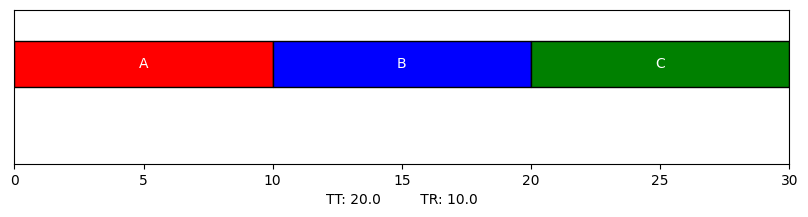

In [62]:
scheduling = fcfs(processes)
print(scheduling)
tt = t_turnaround(scheduling, processes)
tr = t_response(scheduling, processes)
plot_scheduling(scheduling,tt,tr)

[('C', 1), ('A', 4), ('B', 10), ('A', 12), ('B', 13), ('C', 14), ('B', 15), ('C', 16), ('B', 17), ('C', 18), ('A', 19), ('B', 20), ('C', 21), ('B', 22), ('C', 23), ('B', 24), ('A', 25), ('B', 26), ('C', 27), ('A', 28), ('B', 29), ('C', 30)]


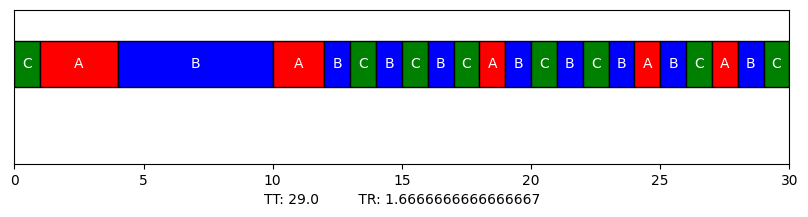

In [63]:
processes = [
    {'name': 'A', 'arrival_time': 0, 'run_time': 10},
    {'name': 'B', 'arrival_time': 0, 'run_time': 10},
    {'name': 'C', 'arrival_time': 0, 'run_time': 10}
]

scheduling = modelo(processes)
print(scheduling)
tt = t_turnaround(scheduling, processes)
tr = t_response(scheduling, processes)
plot_scheduling(scheduling,tt,tr)